In [3]:
#  Import libraries and define variables
import os
import shutil
import glob
from tqdm import tqdm
from PIL import Image
import nibabel as nib
import numpy as np
import pandas as pd
import shutil
import matplotlib.pyplot as plt

import sys
sys.path.append("..")  # Adds the parent directory to sys.path
import config 

# Define the modalities and classifications
# modalities = ['T1', 'T1GD', 'T2', 'FLAIR']
modalities = ['T1']
classifications = ['mgmt_positive', 'mgmt_negative']

# Define patch size and stride
block_h, block_w = config.PATCH_SIZE
stride = 2
# Interpolated image dimensions-
inter_dim = (110, 90)

# Define paths to the BraTS dataset folders
dataset_path = config.DATASET_PATH

PATH = config.MAIN_DIR + 'Data/'
Org_Dir = PATH + 'Original_Data_Backup/'
Work_Dir = PATH + 'Working_Data/'


In [2]:
# Arbitrary functions

def remove_items_starting_with(lst, start_str):
    """
    Remove items from a list that start with the given string.

    Args:
        lst (list): The list from which to remove items.
        start_str (str): The string that items should start with to be removed.

    Returns:
        list: The modified list with items removed.
    """
    # Create a list to store items to be removed
    items_to_remove = []

    # Iterate over the list
    for item in lst:
        if item.startswith(start_str):
            items_to_remove.append(item)

    # Remove items from the list
    for item in items_to_remove:
        lst.remove(item)

    return lst


In [3]:
 # Function Definition --> Backup() Backup Original Data For Safety Purpose

def Backup():
    import shutil
    print('Creating Backup')
    # Copy data for backup
    try:
        shutil.copytree(PATH, Org_Dir) 
    except Exception as e:
        print(e)

    # Copy data for working
    try:
        shutil.copytree(Org_Dir, Work_Dir)
    except Exception as e:
        print(e)

    # Deleting folder, listed in the CATEGORIES list, after creating Cases
    for cate in classifications:
        try:
            shutil.rmtree(PATH + cate)  # Deleting Folders of CATEGORIES list
        except Exception as e:
            print(e)
    print('Backup Created')

In [4]:
# Function Definition --> create_modality_folders() Create Modality Folders For Each Patient

def create_modality_folders():
    print("Copying files into the corresponding modality folders...")
    print(Work_Dir)
    train_folder_1 = os.listdir(Work_Dir)
    for pos_neg in tqdm(train_folder_1):
        patient_folders = os.listdir(os.path.join(Work_Dir, pos_neg))
        for patient_folder in patient_folders:
            for modality in modalities:
                modality_folder_path = os.path.join(Work_Dir, pos_neg, modality)
                # print(modality_folder_path)
                modality_patient_folder_path = os.path.join(modality_folder_path, patient_folder)
                # print(modality_patient_folder_path)
                if not os.path.exists(modality_patient_folder_path):
                    os.makedirs(modality_patient_folder_path)
                
                modality_file_path = os.path.join(Work_Dir, pos_neg, patient_folder, '{}_{}.nii.gz'.format(patient_folder, modality))
                # print(modality_file_path)
                seg_file_path = os.path.join(Work_Dir, pos_neg, patient_folder, '{}_seg.nii.gz'.format(patient_folder))
                # print(seg_file_path)
                if os.path.exists(modality_file_path) and os.path.exists(seg_file_path):
                    shutil.copy(modality_file_path, modality_patient_folder_path)
                    shutil.copy(seg_file_path, modality_patient_folder_path)
                else:
                    print("Either {} or {} does not exist".format(modality_file_path, seg_file_path))
            # delete patient folder after copying files
            shutil.rmtree(os.path.join(Work_Dir, pos_neg, patient_folder))
            

In [5]:
#  Function Definition -- reconstruct() Reconstruction of Working Directory
def reconstruct():
    print('Reconstructing')
    # Deleting working directory
    shutil.rmtree(PATH + "Working_data/")
    # Copying data from backup
    try:
        shutil.copytree(Org_Dir, Work_Dir)
    except:
        print('Working directory already exists')

    print('Reconstruction complete')

In [11]:
# Function Defination --> Generate_images() Generate Images From Nifti Files

def Generate_images():
    print('Generating Images...')
    try:
        workdir = os.listdir(Work_Dir)
        for type in workdir:
            Modality_path = os.path.join(Work_Dir, type + '/')
            modalitypath = os.listdir(Modality_path)
            print("Modality:",modalitypath)
            for modality in modalitypath:
                Patient_path = os.path.join(Modality_path, modality + '/')
                patientpath = os.listdir(Patient_path)
                for patient_folder in patientpath:
                    File_path = os.path.join(Patient_path, patient_folder + '/')
                    filepath = os.listdir(File_path)
                    os.chdir(File_path)
                    patient = patient_folder.split('_')[0] + '_' + patient_folder.split('_')[1]
                    # print("Patient: ",patient)
                    list_of_patients = []
                    # print(File_path)
                    if patient not in list_of_patients:
                        list_of_patients.append(patient)
                        # print(patient)
                        mod = nib.load('{}_{}.nii.gz'.format(patient, modality))
                        mod_data = mod.get_fdata() # Getting the data from the nifti file
                        seg_mask = nib.load('{}_seg.nii.gz'.format(patient))
                        seg_mask_data = seg_mask.get_fdata() # Getting the data from the nifti file  

                        # Extracting layers from mask that have non zero values
                        z = np.any(seg_mask_data, axis=(0,1))
                        zmin, zmax = np.where(z)[0][[0, -1]]  #  zmin & zmax are the first and last layer number non zero values in the z axis

                        # Creating a new mask to remove segmentation
                        d = seg_mask_data
                        for layer in range(zmin, zmax+1):
                             nonzero = np.nonzero(d[:,:,layer])
                             r = nonzero[0]
                             c = nonzero[1]
                             if (r.size == 0) or (c.size == 0):
                                continue
                             rmin = np.min(r)
                             rmax = np.max(r)
                             cmin = np.min(c)
                             cmax = np.max(c)
                             d[rmin:rmax+1, cmin:cmax+1, layer] = 1 #Replacing tumor region values by 1

                        #  Multiply modality data with the new segmentation mask
                        tumor = np.multiply(mod_data, d)

                        # Removing Zero valued layers
                        tumor_layers = tumor[:,:,~(tumor==0).all((0,1))]
                        print(tumor_layers[:, :, 15].shape)
                        plt.imshow(tumor_layers[:, :, 15])

                        # Converting to png files
                        # Cropped_list = []
                        # for lay in range(0, tumor_layers.shape[2]):
                        #     coords = np.argwhere(tumor_layers[:,:,lay])
                        #     x_min, y_min = coords.min(axis=0)
                        #     x_max, y_max = coords.max(axis=0)
                        #     cropped = tumor_layers[x_min:x_max+1, y_min:y_max+1, lay]
                        #     cropped *= (255.0/cropped.max()) # Normalizing the values
                        #     mod_data[:,:,lay] *= (255.0/mod_data[:,:,lay].max())
                        #     Cropped_list.append(mod_data[:,:,lay])   # changed for generating whole slides without crops
                            
                        # frame =0
                        # for item in Cropped_list:
                        #     if ((item.shape[0]*item.shape[1])>= 300):
                        #         frame = frame + 1
                        #         im = Image.fromarray(item)
                        #         im = im.convert('RGB')
                        #         # im = im.resize(inter_dim, Image.Resampling.LANCZOS) # interpolating
                        #         im.save('{}_{}_{}.png'.format(patient, modality, frame))
                        #         im.close()
                        # # Deleting the nifti files
                        # niipath = os.listdir(File_path)
                        # for nii in niipath:
                        #     try:
                        #         if nii.startswith(patient) and nii.endswith('.gz'):
                        #             os.remove(nii)
                        #     except Exception as e:
                        #         print('Error in deleting nifti files')
                        #         print(e)
    except Exception as e:
        print('Error in Generate_images()')
        print(e)

In [7]:
# Function Defination -> Interpolation() Interpolate Images

def Interpolation():
    print('Interpolating...')
    try:
        workdir = os.listdir(Work_Dir)
        if '.DS_Store' in workdir:
            workdir.remove('.DS_Store')
            print('Removed .DS_Store')
        for modality in workdir:
            Modality_path = os.path.join(Work_Dir, modality + '/') # /Users/vitthal/Documents/Research/DataScience/MedicalResearch/mgmt/Data/BRATS/novel_data/Working_Data/MGMT_positive/
            modalitypath = os.listdir(Modality_path)
            if '.DS_Store' in modalitypath:
                modalitypath.remove('.DS_Store')
                print('Removed .DS_Store')
            print("Modality:",modalitypath)
            for patient_folder in modalitypath:
                Patient_path = os.path.join(Modality_path, patient_folder + '/') # /Users/vitthal/Documents/Research/DataScience/MedicalResearch/mgmt/Data/BRATS/novel_data/Working_Data/MGMT_positive/flair/
                patientpath = os.listdir(Patient_path)
                if '.DS_Store' in patientpath:
                    patientpath.remove('.DS_Store')
                    print('Removed .DS_Store')
                # print("Patient:",patientpath)
                for file in patientpath:
                    File_path = os.path.join(Patient_path, file + '/')
                    filepath = os.listdir(File_path)
                    if '.DS_Store' in filepath:
                        filepath.remove('.DS_Store')
                        # print('Removed .DS_Store')
                    # print("File:",len(filepath))
                    # print("Patient Folder:",Patient_path)
                    os.chdir(File_path)
                    # print(File_path)

                    #  Reading the png files
                    pngpath = os.listdir(File_path)
                    if '.DS_Store' in pngpath:
                        pngpath.remove('.DS_Store')
                        # print('Removed .DS_Store')
                    # print("PNG:",len(pngpath))
                    png_list = []
                    for png in pngpath:
                        if png.endswith('.png'):
                            png_list.append(png)
                    # print("PNG:",len(png_list))
                    
                    # print('patient _folders:', patient_folder)
                    
                    # Copy all the modalities in a new folder named 'inter_{}'.format(patient_folder)
                    os.chdir(Modality_path)
                    if not os.path.exists('inter_{}'.format(patient_folder)):
                        shutil.copytree(Patient_path, 'inter_{}'.format(patient_folder))
                            
                    # # finding the maximum width and height of the images in the inter_{} folder
                    # os.chdir(File_path)
                    # pngpath = os.listdir(File_path)
                    # # print('pngpath:', pngpath)
                    # if '.DS_Store' in pngpath:
                    #     pngpath.remove('.DS_Store')
                    #     print('Removed .DS_Store from pngpath')
                    # # print('file path:', File_path) #/Users/vitthal/Documents/Research/DataScience/MedicalResearch/mgmt/Data/BRATS/novel_data/Working_Data/MGMT_positive/flair/BraTS2021_00005/
                    # max_height =0
                    # max_width = 0
                    # for png in pngpath:
                    #     # print('png:', png)
                    #     if png.endswith('.png'):
                    #         # print('here')
                    #         img = Image.open(png)
                            
                    #         width, height = img.size
                    #         if width > max_width:
                    #             max_width = width
                    #         if height > max_height:
                    #             max_height = height
                    #         img.close()
                    # print('max_width:', max_width)
                    # print('max_height:', max_height)

                  
                    # Interpolating the png files and then saving them in the new folder, os.chdir() into the inter_{} folder
                    new_inter_path = os.path.join(Modality_path, 'inter_{}'.format(patient_folder) + '/'+ file + '/')
                    os.chdir(new_inter_path) #/Users/vitthal/Documents/Research/DataScience/MedicalResearch/mgmt/Data/BRATS/novel_data/Working_Data/MGMT_positive/inter_flair/BraTS2021_00005/
                    # print(new_inter_path)
                    new_inter_path_list = os.listdir(new_inter_path)
                    # print(new_inter_path_list)
                    if '.DS_Store' in new_inter_path_list:
                        new_inter_path_list.remove('.DS_Store')
                        print('Removed .DS_Store from new_inter_path_list')
                    png_list = []
                    for png in new_inter_path_list:
                        if png.endswith('.png'):
                            png_list.append(png)
                    for png in png_list:
                        try:
                            image = Image.open(png)
                            image = image.resize(inter_dim, Image.ANTIALIAS)
                            png1 = 'inter_' + png
                            image.save(png1)
                            image.close()
                            os.remove(png)
                        except Exception as e:
                            print('Error in Interpolation()')
                            print(e)

    except Exception as e:
        print('Error in Interpolation() function')
        print(e)

In [8]:
#  Function Defination -> Creating_patches() function

def Creating_patches(block_h, block_w, stride):
    print('Creating patches...')
    try:
        workdir = os.listdir(Work_Dir)
        for mgmt_type in workdir:   # 2 - MGMT_pos and MGMT_neg
            Modality_path = os.path.join(Work_Dir, mgmt_type + '/') # /Users/vitthal/Documents/Research/DataScience/MedicalResearch/mgmt/Data/BRATS/novel_data/Working_Data/MGMT_positive/
            modalitypath = os.listdir(Modality_path)
            for modality in modalities: # 4 - FLair t1 t2 gd
                Patient_path = os.path.join(Modality_path, modality + '/') # /Users/vitthal/Documents/Research/DataScience/MedicalResearch/mgmt/Data/BRATS/novel_data/Working_Data/MGMT_positive/flair/
                patientpath = os.listdir(Patient_path)
                for patient in patientpath:
                    File_path = os.path.join(Patient_path, patient + '/')
                    filepath = os.listdir(File_path)
                    
                    os.chdir(Modality_path)
                    
                    if not os.path.exists(patient):
                        os.mkdir(patient)
                        # shutil.copytree('{}'.format(modality), '{}'.format(patient))

                    # chdir to the patient folder
                    os.chdir(os.path.join(Modality_path, modality + '/'+ patient + '/'))
                    for png in tqdm(glob.glob('*.png')):
                        img = Image.open(png)
                        img_w, img_h = img.size

                        File_Name, extention = os.path.splitext(png)
                        
                        Save_path = os.path.join(Modality_path, patient + '/')
                        # print('Save_path:', Save_path)

                        frame_num = 0
                        count_row = 0

                        for row in range(0, img_h, stride):
                            if (img_h-row >= block_h):
                                count_row += 1
                                count_col = 0

                                for col in range(0, img_w, stride):
                                    if ( img_w -col >= block_w ):
                                        count_col += 1
                                        frame_num += 1

                                        box = (col, row, col+block_w, row+block_h)
                                        a = img.crop(box)
                                        a.save(Save_path + File_Name + '_row_' + str(count_row) + '_col_' + str(count_col) + '.png')
                        
                        img.close()
                        os.remove(png)

                print('Patching done for {} modality'.format(modality))

                # shutil.rmtree(os.path.join(Modality_path, modality))
            print('Patching done for {}'.format(mgmt_type))
                    

    except Exception as e:
        print('Error in Creating_patches() function')
        print(e)

In [9]:
# Function Defination --> Pooling Patches in a single folder

def Pooling_patches():
    print('Pooling patches...')
    try:
        workdir = os.listdir(Work_Dir)
        if '.DS_Store' in workdir:
            workdir.remove('.DS_Store')
            print('Removed .DS_Store')
        for modality in workdir:
            Modality_path = os.path.join(Work_Dir, modality + '/')
            modalitypath = os.listdir(Modality_path)
            if '.DS_Store' in modalitypath:
                modalitypath.remove('.DS_Store')
                print('Removed .DS_Store')
            os.chdir(Work_Dir)
            if not os.path.exists('pool_{}'.format(modality)):
                os.mkdir('pool_{}'.format(modality))
            else:
                print('Directory pool_{} already exists'.format(modality))

            # remove folders starting with the name inter_{} in the modality folder
            modalitypath = remove_items_starting_with(modalitypath, 'inter_')
            # remove folders with the modilty names as declared in the variable in teh first cell
            for item in modalities:
                if item in modalitypath:
                    modalitypath.remove(item)
            
            for patient_folder in modalitypath:
                # Patient Path :  /Users/vitthal/Documents/Research/DataScience/MedicalResearch/mgmt/Data/BRATS/novel_data/Working_Data/MGMT_positive/flair/
                Patient_path = os.path.join(Modality_path, patient_folder + '/')
                patientpath = os.listdir(Patient_path)
                if '.DS_Store' in patientpath:
                    patientpath.remove('.DS_Store')
                    print('Removed .DS_Store')
                # print("Patient:",patientpath)
                for file in tqdm(patientpath):
                    File_path = os.path.join(Patient_path, file + '/')
                    filepath = os.listdir(File_path)
                    if '.DS_Store' in filepath:
                        filepath.remove('.DS_Store')
                        print('Removed .DS_Store')
                        # print("File:", File_path)

                    for patch in filepath:
                        Patch_path = os.path.join(File_path, patch + '/')
                        patchpath = os.listdir(Patch_path)
                        if '.DS_Store' in patchpath:
                            patchpath.remove('.DS_Store')
                            print('Removed .DS_Store')
                        for pacth_img in patchpath:
                            Patch_img_path = os.path.join(Patch_path, pacth_img)
                            shutil.copy(Patch_img_path, os.path.join(Work_Dir, 'pool_{}'.format(modality)))
                            # os.remove(Patch_img_path)

                    # #  copy images from individual folders to a single folder named pool_{modality}
                    # os.chdir(File_path)
                    # patches = os.listdir(File_path)
                    # if '.DS_Store' in patches:
                    #     patches.remove('.DS_Store')
                    # print(patches) 
                    # # print(os.path.join(Work_Dir, 'pool_{}'.format(modality) + '/'+ file + '/'))
                    # os.path.join(Work_Dir, 'pool_{}'.format(modality) + '/'+ file + '/')
                    # Copy all the modalities in a new folder named 'patch_{}'.format(patient_folder)
                    # os.chdir(Modality_path)
                    # if not os.path.exists('pool_{}'.format(modality) + '/'+ file + '/'):
                    #     shutil.copytree(os.path.join(File_path), os.path.join(Work_Dir, 'pool_{}'.format(modality) + '/'+ file + '/'))
                    


                        # shutil.copytree(File_path, os.path.join(Work_Dir, 'pool_{}'.format(modality) + '/'+ file + '/'))

    except Exception as e:
        print('Error in Pooling_patches() function')
        print(e)

In [10]:
# Recording patient with patches done
def update_patch_record():
    os.chdir(config.MAIN_DIR)
    patch_df = pd.read_csv(config.MAIN_DIR + 'Codes/upenn_data.csv')

    for mgmt_type in os.listdir(Work_Dir):

        # Delete existing Moadlity empty folders if any
        for modality in modalities:
            if modality in os.listdir(Work_Dir + mgmt_type + '/'):
                shutil.rmtree(Work_Dir + mgmt_type + '/' + modality)

        
        # update the csv with patches of patients
        for patient in os.listdir(Work_Dir + mgmt_type + '/'):
            patch_df.loc[patch_df.id == patient, 'patches64'] = True  # mention the patches colmun to update

    patch_df.to_csv(config.MAIN_DIR + 'Codes/upenn_data.csv', index=False)



In [11]:
# Main cell to invoke functions

# Backup the original data
# Backup()

In [12]:
# reconstruct the working data
# reconstruct()

Reconstructing
Reconstruction complete


In [13]:
# create modality folders
# create_modality_folders()

Copying files into the corresponding modality folders...
D:/MGMT research project/Data/Working_Data/


100%|██████████| 2/2 [00:09<00:00,  4.97s/it]


Generating Images...
Modality: ['T1']
(240, 240)
Modality: ['T1']
(240, 240)


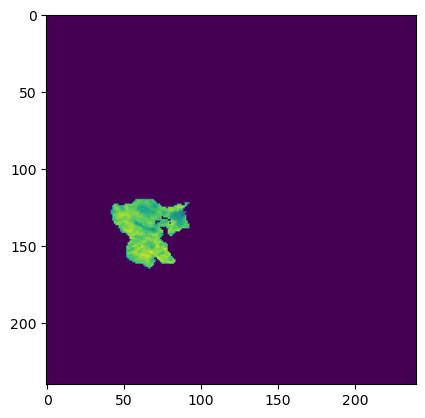

In [12]:
# Generate images from nifti files
Generate_images()

In [ ]:
# Creating patches
# Creating_patches(block_h, block_w, stride)


In [ ]:
# update_patch_record()